# Анализ предпочтения игр NA, EU и JP рынков за 1980-2016гг.

В этом проекте мы рассмотрим предпочтения трех рынков по игровым приставкам, жанрам и возрастным рейтингам жителей Северной Америки, Европы и Японии. Рассмотрим различия между прямыми конкурентами в игровой сфере американскими и японскими разработчиками.

В  истории игровых приставок различные модели часто объединяют в «поколения» — группы с общими годами продаж и схожим аппаратным и программным оснащением. Под давлением рынка производители каждые несколько лет вынуждены разрабатывать и выпускать новые приставки, заменяя устаревшие модели, так что развитие игровых приставок подчиняется повторяющимся циклам разработки и производства. Рассчитаем "среднюю продолжительность жизни" игровой консоли.

Спрогназируем успех продаж игровых платформ на 2017г.

In [1]:
pip install missingno 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats as st
import copy
import missingno as msno

from pandas.core.common import SettingWithCopyWarning
import warnings

from scipy.stats import ttest_ind # для проверки гипотезы


warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

pd.options.display.float_format = '{:.2f}'.format

## Шаг 1. Загрузка данных

In [3]:
data = pd.read_csv('/datasets/games.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Выведем информацию  о данных. В таблице 10 столбцов, 16715 строк. Без пропусков предположительно столбцы о продажах, в остальных сериях от 2 до нескольких тысяч пропусков.

In [5]:
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.00,16715.00,16715.00,16715.00,16715.00,8137.00
mean,2006.48,0.26,0.15,0.08,0.05,68.97
std,5.88,0.81,0.50,0.31,0.19,13.94
min,1980.00,0.00,0.00,0.00,0.00,13.00
25%,2003.00,0.00,0.00,0.00,0.00,60.00
50%,2007.00,0.08,0.02,0.00,0.01,71.00
75%,2010.00,0.24,0.11,0.04,0.03,79.00
max,2016.00,41.36,28.96,10.22,10.57,98.00


In [6]:
data

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.00,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.00,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.00,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.00,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


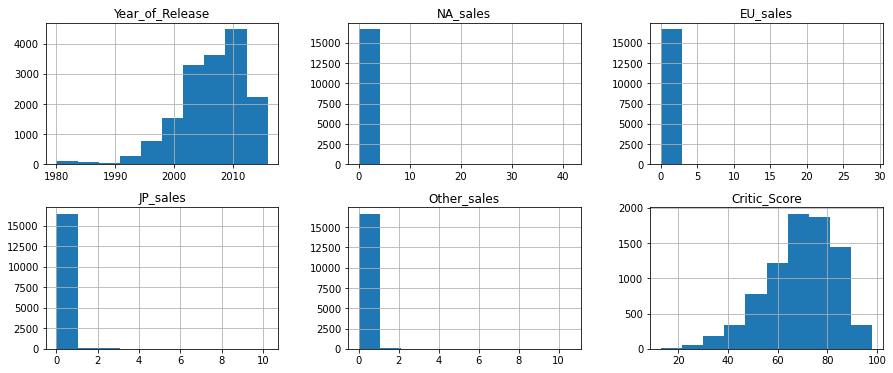

In [7]:
data.hist(figsize=(15,6), layout=(2, 3))
plt.show()

Выводим гистограммы, по первой видно, что игры начали набирать активность с конца 90-х гг, и после 2011 пошел некоторый спад. Имеются числовые колонки по продажам и оценке критиков(100-бальная шкала).

## Шаг 2. Предобработка данных

Перейдем к шагу подготовки данных для дальнейшего анализа, в этом блоке нам предстоит преобразовать регистр, типы данных, а так же изучить природу пропусков, обработать их и добавить новый столбец с суммарными продажами.

При загрузке данных мы обнаружили, что наименования столбцов записаны с использованием верхнего и нижнего регистра, выведем данные, и при необходимости переведем их в нижний.

In [8]:
data.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [9]:
data.columns = data.columns.str.lower()

In [10]:
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Использую матрицу для изучения пропусков, предварительный анализ потверждается, в столбце года выпуска имеются пробелы; оценки критиков, пользователей и столбец с рейтингом ESRB имеют больше всего пропусков.

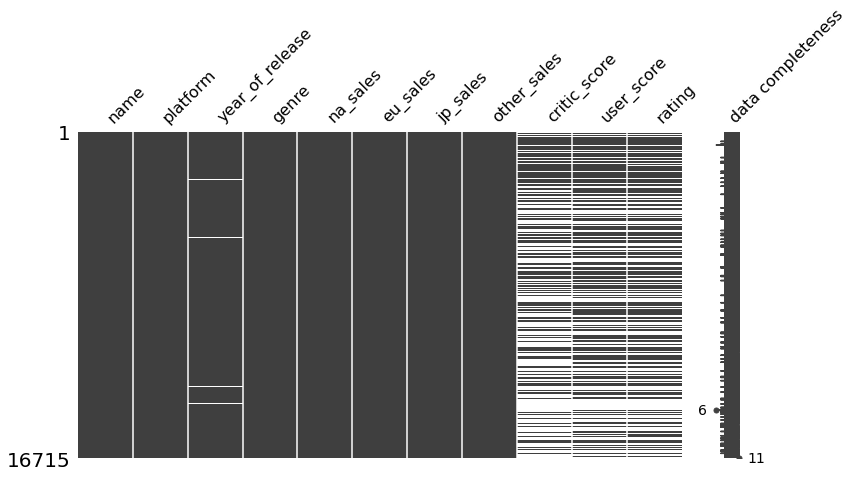

In [14]:
msno.matrix(data, labels=True, figsize=(12,6));

In [15]:
print((data.isnull().sum()/len(data))*100)

name               0.01
platform           0.00
year_of_release    1.61
genre              0.01
na_sales           0.00
eu_sales           0.00
jp_sales           0.00
other_sales        0.00
critic_score      51.32
user_score        40.09
rating            40.48
dtype: float64


В процентном соотношении: год выпуска чуть более 1.5% пропусков, менее 0.05% в столбце жанра и наименования продукта, и более 40 % по оценкам пользователей и рейтинга ESRB,  оценки критиков имеют более всего пропусков.

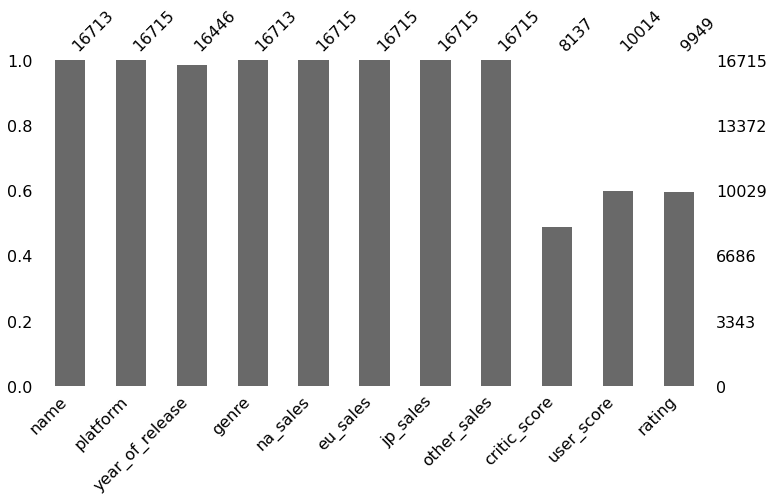

In [16]:
msno.bar(data, figsize=(12,6));

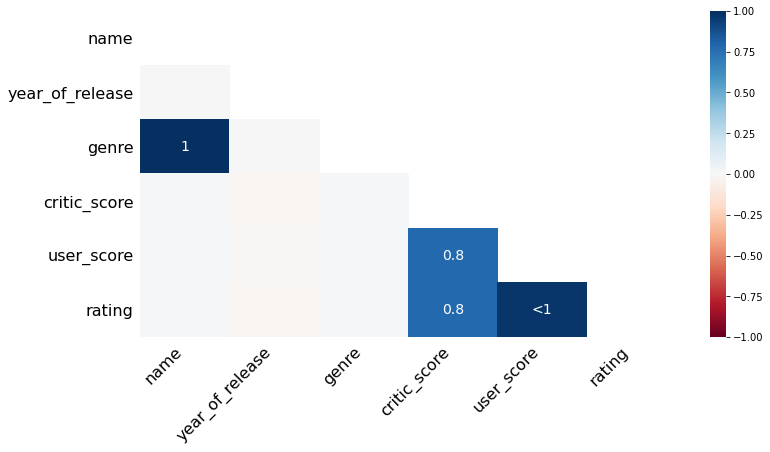

In [17]:
msno.heatmap(data, figsize=(12,6));

Корреляция зависимоти пропусков подсказывает, что имеется сильная зависимость пропуск по жанру и наименованию продукта, достаточно сильная между оценками критиков, пользователей и рейтинга ESRB.

Выведем пропуски по имени и жанру(так как между ними сильная корреляция).

In [18]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.00,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.00,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [19]:
data[data['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.00,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.00,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Пропуск в имени совпадает с пропуском в жанре у обоих игр 1993г, так же ни одного оценочного критерия в них нет. Удалим две строки, так как их восстановление не предоставляется возможным.

In [20]:
data.drop([659, 14244],inplace=True)

Изучим столбец года выпуска, посмотрим уникальные значения и пропуски в нем.

In [21]:
data['year_of_release'].sort_values().unique()

array([1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988.,
       1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997.,
       1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006.,
       2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
       2016.,   nan])

Игры с годом выпуска от 1980 до 2016 года, период в 36 лет предстоит изучить.

In [22]:
data[data['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.00,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.00,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.00,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.00,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.00,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.00,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [23]:
year = data[data['year_of_release'].isna()]

In [24]:
year.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269 entries, 183 to 16522
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             269 non-null    object 
 1   platform         269 non-null    object 
 2   year_of_release  0 non-null      float64
 3   genre            269 non-null    object 
 4   na_sales         269 non-null    float64
 5   eu_sales         269 non-null    float64
 6   jp_sales         269 non-null    float64
 7   other_sales      269 non-null    float64
 8   critic_score     154 non-null    float64
 9   user_score       175 non-null    object 
 10  rating           181 non-null    object 
dtypes: float64(6), object(5)
memory usage: 25.2+ KB


In [25]:
cols = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']

In [26]:
year['sum'] = year[cols].sum(axis= 1 )

In [27]:
year

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.00,8.5,E,5.24
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.00,6.4,E,3.50
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.00,7.9,E10+,3.06
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,3.00
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN,2.53
...,...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.00,tbd,E10+,0.01
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.00,6.5,T,0.01
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.00,6.7,M,0.01
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


In [28]:
year['sum'].sum()

98.91999999999999

269 строк пропусков,  менее 1.5%. Принимаю решение на удаление пропущенных данных, хоть мы и видим, что в некоторых строках имеется маркировка года(в спортивном сегменте), при этом мы не можем утверждать, что игра принадлежит конкретно этому году выпуска. Если же попробовать восстановить по другим платформам, то в этом случае мы будем накапливать ошибку, так как разница между выходом игры на одной и другой платформе может доходить до 5-ти лет.

In [29]:
data=data.dropna(subset=['year_of_release'])

In [30]:
data['year_of_release'] = data['year_of_release'].astype(np.int32)

В наших данных год это целочисленное значение, переведем его в таковое и понизим разрядность данных.

In [31]:
print((data.isnull().sum()/len(data))*100)

name               0.00
platform           0.00
year_of_release    0.00
genre              0.00
na_sales           0.00
eu_sales           0.00
jp_sales           0.00
other_sales        0.00
critic_score      51.45
user_score        40.17
rating            40.60
dtype: float64


Еще раз выведу процентное соотношение пропусков, столбцы с оценками изучим чуть позднее. От пропусков в имени, жанре и годе мы избавились(менее 1.7% от всех данных). Столбцам с оценками и продажами понизим разрядность до float32 для уменьшения размера таблицы и ввиду отсутсвия необходимости хранения больших чисел, сделаем это через цикл.

In [32]:
cols = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score']

for col in cols:
    data[col] = data[col].astype(np.float32)

Изучим столбец пользовательских оценок, от 0 до 9.7. Тbd и nan, второе значение известно, это пропуск, первое рассмотрим ниже. 

In [33]:
data['user_score'].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

Тbd- будет определено позднее(to be determined), рейтинг неизвестен. Выведем все оценки "tbd", 2376 строк, заменим их на пропуски, так как фактически у нас стоит пропуск в значениях рейтинга.

In [34]:
data.query('user_score =="tbd"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.00,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.00,0.54,61.00,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.00,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.00,0.20,71.00,tbd,E
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.00,0.18,NaN,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.00,0.00,67.00,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.00,0.00,53.00,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.00,0.00,48.00,tbd,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.00,0.00,NaN,tbd,E


In [35]:
data['user_score'] = data['user_score'].replace('tbd', np.NaN)

In [36]:
data['user_score'] = data['user_score'].astype('float32')

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float32
 5   eu_sales         16444 non-null  float32
 6   jp_sales         16444 non-null  float32
 7   other_sales      16444 non-null  float32
 8   critic_score     7983 non-null   float32
 9   user_score       7463 non-null   float32
 10  rating           9768 non-null   object 
dtypes: float32(6), int32(1), object(4)
memory usage: 1.1+ MB


После преобразования данных, посмотрим информацию о таблице, 4 объектных значения, остальные же переведены в целочисленные или дробные значения в понижением разрядности до 32-х б.

In [38]:
data[data['critic_score'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [39]:
data['critic_score'].sort_values().unique()

array([13., 17., 19., 20., 21., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
       44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
       70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82.,
       83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.,
       96., 97., 98., nan], dtype=float32)

In [40]:
data['critic_score'].describe()

count   7983.00
mean      68.99
std       13.92
min       13.00
25%       60.00
50%       71.00
75%       79.00
max       98.00
Name: critic_score, dtype: float64

In [41]:
data['critic_score'] = data['critic_score'].apply(np.round).astype('Int32')

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float32
 5   eu_sales         16444 non-null  float32
 6   jp_sales         16444 non-null  float32
 7   other_sales      16444 non-null  float32
 8   critic_score     7983 non-null   Int32  
 9   user_score       7463 non-null   float32
 10  rating           9768 non-null   object 
dtypes: Int32(1), float32(5), int32(1), object(4)
memory usage: 1.1+ MB


In [43]:
data['critic_score'].sort_values().unique()

<IntegerArray>
[  13,   17,   19,   20,   21,   23,   24,   25,   26,   27,   28,   29,   30,
   31,   32,   33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
   44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,   55,   56,
   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,   67,   68,   69,
   70,   71,   72,   73,   74,   75,   76,   77,   78,   79,   80,   81,   82,
   83,   84,   85,   86,   87,   88,   89,   90,   91,   92,   93,   94,   95,
   96,   97,   98, <NA>]
Length: 82, dtype: Int32

Информация о оценке критиков представляет собой целочисленное значачение, приведем его в таковое, пропусков в данном столбце почти 9 тыс. Оставим столбец без преобразований, так как не представляется возможным поставить оценку за критиков. Есть несколько версий почему оценок нет, от неучастия в рейтингах до отсутсвия таковых в момент выпуска(например ранние продукты).

In [44]:
data[data['user_score'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,<NA>,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,<NA>,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,<NA>,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,<NA>,NaN,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,<NA>,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,<NA>,NaN,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,<NA>,NaN,NaN


In [45]:
data['user_score'].sort_values().unique()

array([0. , 0.2, 0.3, 0.5, 0.6, 0.7, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5,
       1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8,
       2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1,
       4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3, 5.4,
       5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7,
       6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. ,
       8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1, 9.2, 9.3,
       9.4, 9.5, 9.6, 9.7, nan], dtype=float32)

In [46]:
data['user_score'].describe()

count   7463.00
mean       7.13
std        1.50
min        0.00
25%        6.40
50%        7.50
75%        8.20
max        9.70
Name: user_score, dtype: float64

Пользовательские оценки представлены от 0 до 10, в дробном виде, с пропусками около 9 тыс, так же не представляется возможным поставить оценки  играм за пользователей, причина может быть так же, как и в предыдущем случае, отсутствие или не участие в рейтингах.

In [47]:
data[data['rating'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,<NA>,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,<NA>,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,<NA>,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,<NA>,NaN,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,<NA>,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,<NA>,NaN,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,<NA>,NaN,NaN


В таблице есть рейтинг Entertainment Software Rating Board — негосударственная организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде. ESRB была основана в 1994 году ассоциацией Interactive Digital Software Association

In [48]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)



- 'E' -  («Everyone») — «Для всех»
- 'M' - («Mature») — «Для взрослых»
- 'T' - («Teen») — «Подросткам»
- 'E10+' - («Everyone 10 and older») — «Для всех от 10 лет и старше»
- 'K-A' - (Kids to Adults) but was changed in 1998)
- 'AO' - («Adults Only 18+») — «Только для взрослых»
- 'EC' - («Early childhood») — «Для детей младшего возраста»
- 'RP'  - «RP» («Rating Pending») — «Рейтинг ожидается»

In [49]:
data['rating'].describe()

count     9768
unique       8
top          E
freq      3921
Name: rating, dtype: object

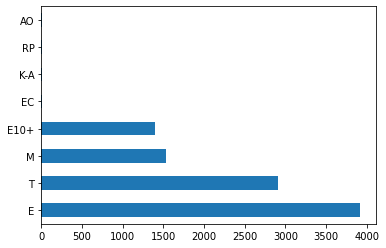

In [50]:
data['rating'].value_counts().plot(kind='barh');

In [51]:
data.query('rating == ["K-A", "EC", "AO", "RP"]')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
656,Theme Hospital,PC,1997,Strategy,2.30,0.10,0.00,0.00,<NA>,9.00,K-A
875,Grand Theft Auto: San Andreas,XB,2005,Action,1.26,0.61,0.00,0.09,93,8.60,AO
903,PaRappa The Rapper,PS,1996,Misc,0.26,0.16,1.46,0.03,92,7.40,K-A
4297,Nickelodeon Team Umizoomi,DS,2011,Action,0.42,0.00,0.00,0.03,<NA>,NaN,EC
5034,Sesame Street: Elmo's A-to-Zoo Adventure,Wii,2010,Misc,0.35,0.00,0.00,0.02,<NA>,NaN,EC
6046,Sesame Street: Cookie's Counting Carnival,Wii,2010,Misc,0.27,0.00,0.00,0.02,<NA>,NaN,EC
6764,Dora the Explorer: Journey to the Purple Planet,PS2,2005,Adventure,0.12,0.09,0.00,0.03,<NA>,7.00,EC
7586,"Ni Hao, Kai-lan: New Year's Celebration",DS,2009,Misc,0.19,0.00,0.00,0.01,<NA>,NaN,EC
9960,Dora the Explorer: Journey to the Purple Planet,GC,2005,Adventure,0.09,0.02,0.00,0.00,<NA>,NaN,EC
13065,Sesame Street: Cookie's Counting Carnival,PC,2010,Misc,0.05,0.00,0.00,0.00,<NA>,NaN,EC


In [52]:
data['rating'] = data['rating'].replace('K-A', 'E10+')
data['rating'] = data['rating'].replace('EC', 'E')

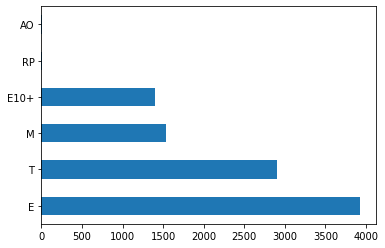

In [53]:
data['rating'].value_counts().plot(kind='barh');

In [54]:
data.loc[data['year_of_release'] < 1994, 'rating'] = 'NoRating'

In [55]:
data['rating'] = data['rating'].fillna('RP')

Заменим пропуски на значения до 1994 'NoRating' и 'RP' после('RP' - «RP» («Rating Pending») — «Рейтинг ожидается»)

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float32
 5   eu_sales         16444 non-null  float32
 6   jp_sales         16444 non-null  float32
 7   other_sales      16444 non-null  float32
 8   critic_score     7983 non-null   Int32  
 9   user_score       7463 non-null   float32
 10  rating           16444 non-null  object 
dtypes: Int32(1), float32(5), int32(1), object(4)
memory usage: 1.1+ MB


16444 значений в столбце рейтинга, рейтинги пользователей и критиков восстановить без искажения данных невозможно.

In [57]:
data.duplicated().sum()

0

Проверка на дубликаты показала, что их нет.

In [58]:
display(data[data.duplicated(subset = ['name',  'platform',  'year_of_release'], keep = 'first')])
display(data[data.duplicated(subset = ['name',  'platform',  'year_of_release'], keep = 'last')])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.00,0.00,83,5.50,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.00,0.23,83,5.50,E


In [59]:
data = data.drop_duplicates(subset=['name', 'platform'])

In [60]:
display(data[data.duplicated(subset = ['name',  'platform',  'year_of_release'])])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


In [61]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] +  data['jp_sales'] + data['other_sales']

In [62]:
data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.00,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,NoRating,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.30,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.00,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,RP,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,<NA>,NaN,RP,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,<NA>,NaN,RP,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,<NA>,NaN,RP,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,<NA>,NaN,RP,0.01


Создадим столбец с суммарными продажами, после вывода таблицы проверяю его наличие в ней.

**Вывод:** при предобработке данных были выполнены такие действия как: перевод заголовков в нижний регистр, обработка пропусков в столбцах жанра и имени, года выпуска, замена tbd на nan в оценках пользователей, в ESRB рейтингах были произведены замены пропусков на RP, NoRating, объединены некоторые категории, а так же принято решение не обрабатывать пропуски в оценочных столбцах критиков и пользователей, так как это может навредить достоверности данным. Данные были понижены в разряде для экономии ресурса.

## Шаг 3. Проведите исследовательский анализ данных

В исследовательском анализе изучим детально параметры года выпусков, а так же популярность жанров, платформ.

###  Изучение года выпуска.

Рассмотрим таблицу года выпуска и количество игр.

In [63]:
year_release = data.pivot_table(index='year_of_release',  values='name', aggfunc='count')

In [64]:
year_release.rename(columns = {'name' : 'QTY'}, inplace = True)

In [65]:
year_release

,QTY
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


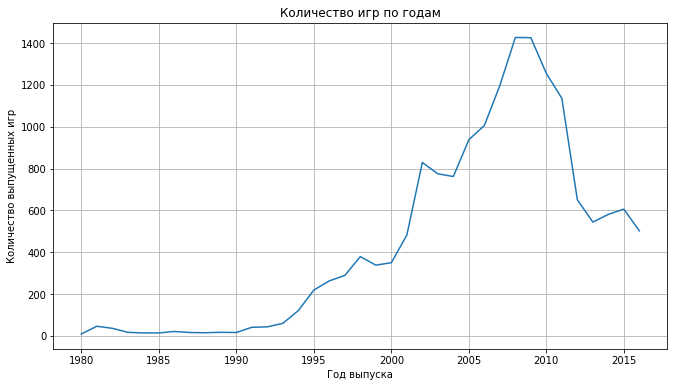

In [66]:
year_release.plot( figsize = (11,6), grid = True, legend=False) 
plt.title('Количество игр по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Количество выпущенных игр');

Как видно из графика и таблицы активные выпуски игр стартовали с 2002 и пиком в 2008(вплоть до мирового экономического кризиса 2008), 6 лет активного роста как продуктов так и их популярности. Спад пошел в 2011 году, то есть, во время активной фазы спада экономического кризиса. Стоит признать, что игровая отрасль 3 года держала докризисные показатели, предполагаю, что некоторые продукты были выпущены с некоторой задержкой, что помогло держаться на плаву сфере компьютерных игр.

### Изучим популярность платформ.

In [67]:
platforms = data.pivot_table(index='platform',  values='total_sales',
                             aggfunc='sum').sort_values(by='total_sales', ascending=False)

In [68]:
platforms

,total_sales
platform,
PS2,1233.56
X360,959.99
PS3,931.33
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


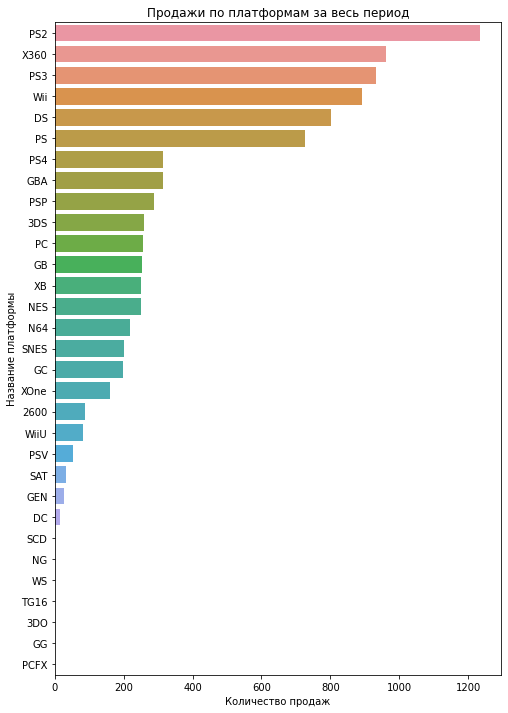

In [69]:
plt.figure(figsize=(8,12))
sns.barplot(x=platforms['total_sales'], y=platforms.index, orient='h')
plt.title("Продажи по платформам за весь период")
plt.xlabel("Количество продаж")
plt.ylabel("Название платформы");

'PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS' - лидеры продаж за весь период, 3  поколения японской приставки playstaion, Nintendo Wii и DS, американская платформа microsoft X360

In [70]:
data.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
2600,116.00,0.75,0.96,0.07,0.31,0.48,0.78,7.81
3DO,3.00,0.03,0.02,0.02,0.02,0.02,0.04,0.06
3DS,512.00,0.50,1.44,0.01,0.05,0.12,0.33,14.60
DC,52.00,0.31,0.47,0.02,0.08,0.13,0.30,2.41
DS,2121.00,0.38,1.44,0.01,0.05,0.11,0.27,29.80
GB,97.00,2.62,5.39,0.06,0.30,1.18,2.18,31.38
GBA,811.00,0.39,0.90,0.01,0.05,0.16,0.39,15.84
GC,542.00,0.36,0.69,0.01,0.06,0.15,0.37,7.06
GEN,27.00,1.05,1.49,0.03,0.07,0.15,1.70,6.02


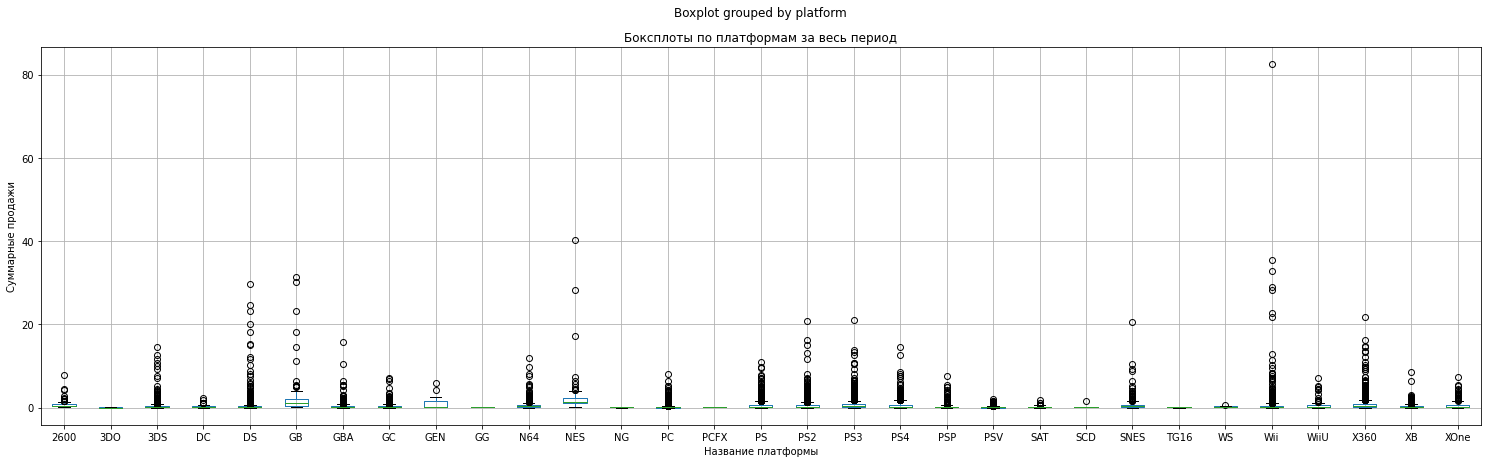

In [71]:
data.boxplot(column='total_sales', by='platform', figsize=(25,7))
plt.title("Боксплоты по платформам за весь период")
plt.xlabel("Название платформы")
plt.ylabel("Суммарные продажи")
plt.show()

Из графика видно, что у Nintendo есть свойство "выстреливать" продуктами, в то время, как Мicrosoft достаточно методично снебольшими выбросами поднимает продажи.

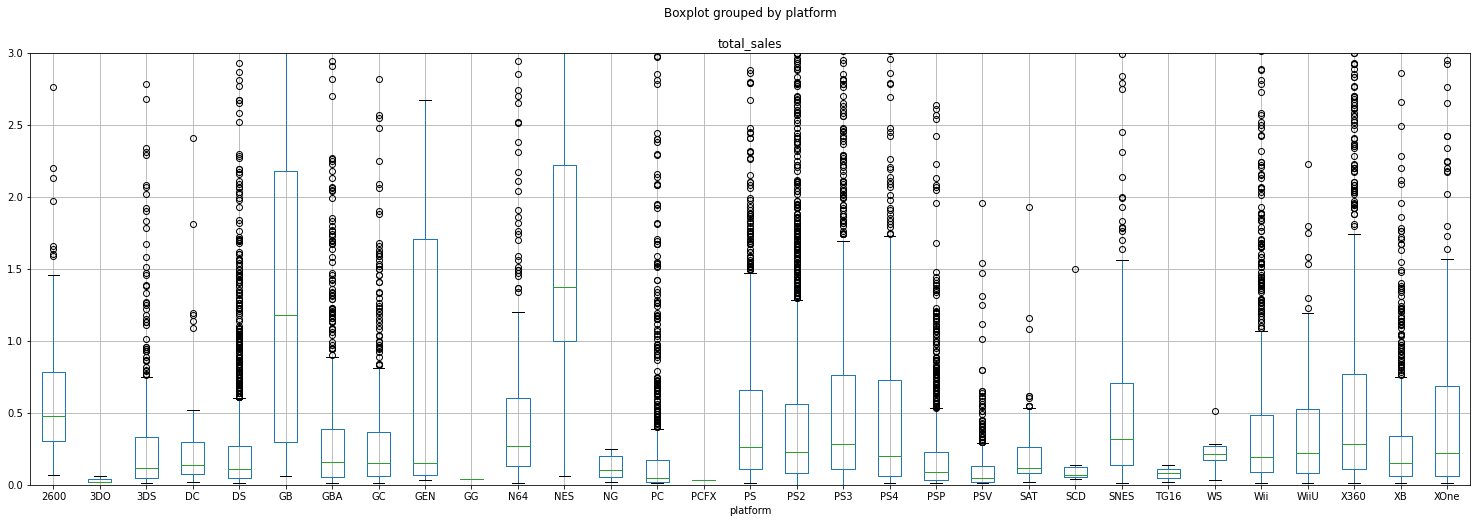

In [72]:
data.boxplot(column='total_sales', by='platform', figsize=(25,8))
plt.ylim(0, 3);

При более детальном рассмотрении подтверждается анализ, серия "Икс бокс" поддерживает популярность с менее частыми попаданиями на пик продаж. Скорее всего, платформа придерживается своего сегмента, что обеспечивает такую популярность и живучесть проектов.

In [73]:
popular_platforms = list(platforms.index[:6])
popular_platforms

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

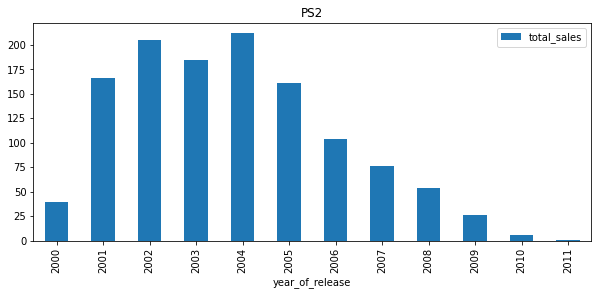

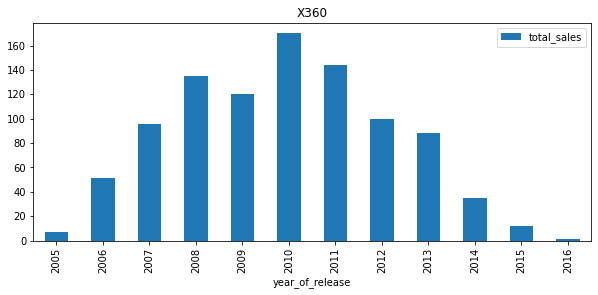

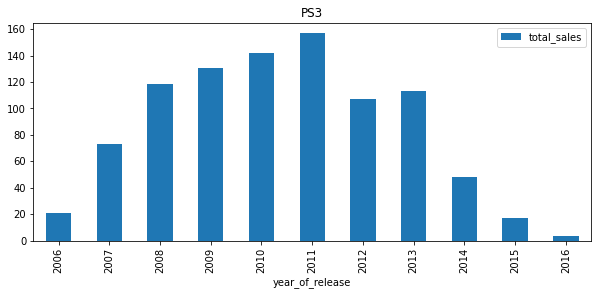

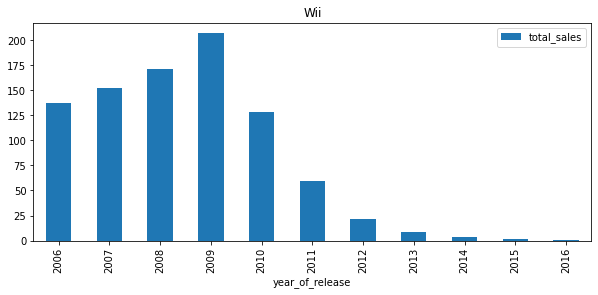

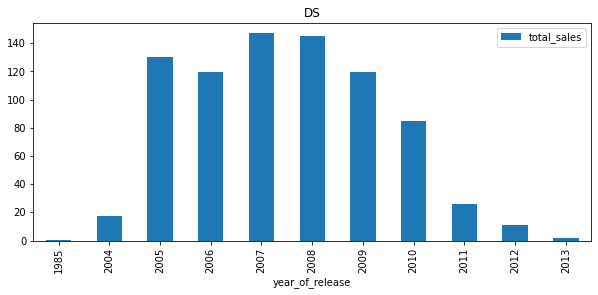

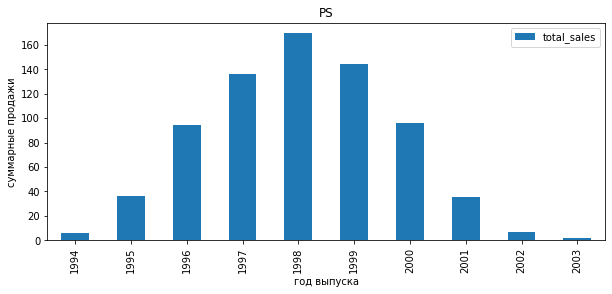

In [74]:
for platform in popular_platforms:
    data[data['platform'] == platform].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(
        kind='bar', 
        figsize=(10,4),
        title = platform)
    
plt.xlabel('год выпуска')
plt.ylabel('суммарные продажи');

Рассмотри диаграммы наиболее популярных платформ. Американцы только с 2006 года упрочили свои позиции на рынке, японские приставки набрали популярность за долго до, с 1996 PS с дальнейшим развитием платформ, Nintendo с 2005.

In [75]:
for platform in popular_platforms:
   
    platforms = pd.pivot_table(data.query('platform == @platform'), index=['platform','year_of_release'], values='total_sales',
                               aggfunc='sum').sort_values(by='year_of_release')
    print(platforms)
    print()

                          total_sales
platform year_of_release             
PS2      2000                   39.17
         2001                  166.43
         2002                  205.38
         2003                  184.31
         2004                  211.81
         2005                  160.66
         2006                  103.42
         2007                   75.99
         2008                   53.90
         2009                   26.40
         2010                    5.64
         2011                    0.45

                          total_sales
platform year_of_release             
X360     2005                    7.00
         2006                   51.62
         2007                   95.41
         2008                  135.26
         2009                  120.29
         2010                  170.03
         2011                  143.84
         2012                   99.74
         2013                   88.58
         2014                   34.74
         20

In [76]:
data_new = data.query('platform == @popular_platforms')

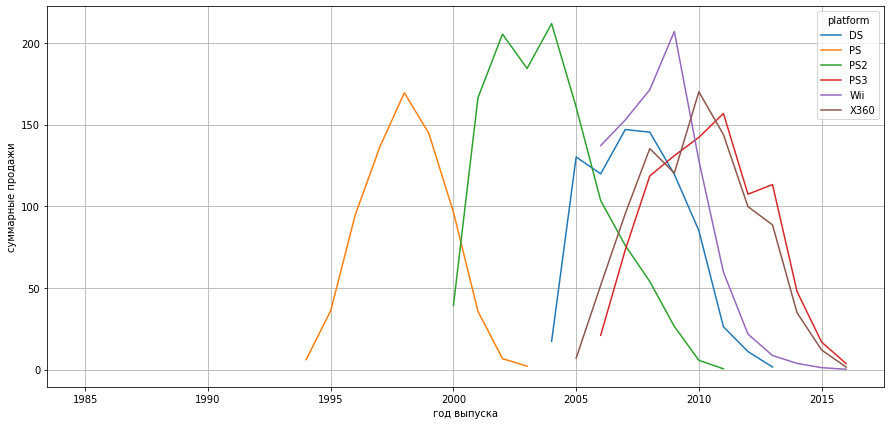

In [77]:
data_new.pivot_table(index='year_of_release', columns = 'platform', 
                     values='total_sales', aggfunc='sum').plot(grid=True, figsize=(15, 7))
plt.xlabel('год выпуска')
plt.ylabel('суммарные продажи');

На таблице выше мы видим "среднюю жизнь" игровой приставки. В среднем, этот период можно обозначить в 7 лет, далее идет спад и необходимость создавать что-то новое для поддержания интереса покупателей.

In [78]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9260 entries, 0 to 16711
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             9260 non-null   object 
 1   platform         9260 non-null   object 
 2   year_of_release  9260 non-null   int32  
 3   genre            9260 non-null   object 
 4   na_sales         9260 non-null   float32
 5   eu_sales         9260 non-null   float32
 6   jp_sales         9260 non-null   float32
 7   other_sales      9260 non-null   float32
 8   critic_score     4443 non-null   Int32  
 9   user_score       4243 non-null   float32
 10  rating           9260 non-null   object 
 11  total_sales      9260 non-null   float32
dtypes: Int32(1), float32(6), int32(1), object(4)
memory usage: 660.1+ KB


In [79]:
DS = data_new.query('platform == "DS"')

In [80]:
DS.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.50,E,29.80
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,<NA>,NaN,RP,24.67
11,Mario Kart DS,DS,2005,Racing,9.71,7.47,4.13,1.90,91,8.60,E,23.21
19,Brain Age: Train Your Brain in Minutes a Day,DS,2005,Misc,4.74,9.20,4.16,2.04,77,7.90,E,20.14
20,Pokemon Diamond/Pokemon Pearl,DS,2006,Role-Playing,6.38,4.46,6.04,1.36,<NA>,NaN,RP,18.24


In [81]:
DS['total_sales'].sum()

802.78

Почти 10% от всех продаж, активные продажи с 2005-2009 гг, потом спад в течении 3-х лет, далее сходит на нет продажи.

In [82]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [83]:
data_new.groupby(['platform'])['na_sales', 'eu_sales',
                               'jp_sales', 'other_sales', 'total_sales'].sum().sort_values(by = 'total_sales', ascending=False)

,na_sales,eu_sales,jp_sales,other_sales,total_sales
platform,,,,,
PS2,572.92,332.63,137.54,190.47,1233.56
X360,594.74,268.19,12.28,84.78,959.99
PS3,390.13,327.20,79.41,134.59,931.33
Wii,486.87,258.32,68.28,77.71,891.18
DS,380.31,188.41,175.02,59.04,802.78
PS,334.72,212.39,139.78,40.69,727.58


Из списка самых популярных платформ, выделим PS2 - игровая приставка стала самой продаваемой и самой популярной игровой консолью в истории. На третий квартал 2011 года в мире продано почти 155 миллионов экземпляров PS2. Приставка выпускалась почти 13 лет, это один из самых длинных жизненных циклов в истории игровой индустрии.

Для дальнейшего прогноза актуальности приставок беру период в  3 года(средняя продолжительность интереса к консоли 7 лет). Во-первых, такую продолжительность я беру для того, чтобы оценить поведение производителя на рынке и есть ли вероятность того, что он "выстрелит" с продуктом.

In [84]:
data_1 = data.query("2013 <= year_of_release <= 2016")

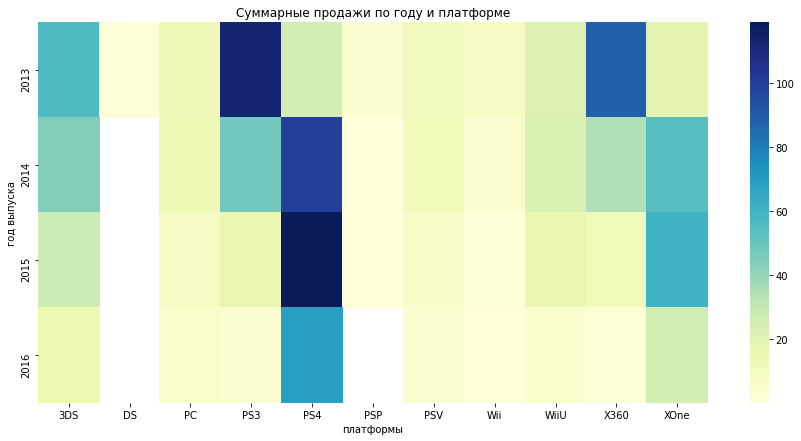

In [85]:
period=data_1.pivot_table(index='year_of_release', columns = 'platform',
                          values='total_sales', aggfunc='sum')
plt.figure(figsize=(15, 7))
sns.heatmap(period, cmap='YlGnBu')
plt.title('Суммарные продажи по году и платформе')
plt.xlabel('платформы')
plt.ylabel('год выпуска');
plt.show()

Из тепловой карты видно, как активно началась конкуренция между американской и японской платформой со стартом продуктов PS4 и XOne в один год, но стоит отметитиь, что полюбившиеся playstation  прочно одерживают топовые позиции. Кстати, на карте так же видно, что старые продукты игровых холдингов Японии несмотря на прекращение выпуска консоли удерживают прочные позиции в продажах(Nintendo 3DS окончили свое приозводство в 2011 году, но продажи и перепродажи до сих пор продолжаются).

In [86]:
data_1.groupby(['platform'])['na_sales', 'eu_sales','jp_sales',
                             'other_sales', 'total_sales'].sum().sort_values(by = 'total_sales', ascending=False)

,na_sales,eu_sales,jp_sales,other_sales,total_sales
platform,,,,,
PS4,108.74,141.09,15.96,48.35,314.14
PS3,63.50,67.81,23.35,26.77,181.43
XOne,93.12,51.59,0.34,14.27,159.32
3DS,38.20,30.96,67.81,6.28,143.25
X360,81.66,42.52,0.51,12.11,136.80
WiiU,29.21,19.85,10.88,4.69,64.63
PC,11.11,25.36,0.00,2.96,39.43
PSV,5.04,6.10,18.59,3.26,32.99
Wii,6.56,5.93,0.05,1.12,13.66


Закономерная ситуация на рынке игровых платформ, американская платформа лидер продаж в Северной Америке, PS 3, 4, 2 в Европе, Японии, а вот Nintendo все-таки покорила Северо-Американский рынок, и продаж на континенте Свободы в разы выше, чем на родине производителя.

 Рассмотрим поведение на рынке с 2013 по 2016 год.

In [87]:
best_sales = pd.pivot_table(data_1, index=['platform','year_of_release'], 
                                     values='total_sales', aggfunc = 'sum')
best_sales

total_sales
platform year_of_release             
3DS      2013                   56.57
         2014                   43.76
         2015                   27.78
         2016                   15.14
DS       2013                    1.54
PC       2013                   12.38
         2014                   13.28
         2015                    8.52
         2016                    5.25
PS3      2013                  113.25
         2014                   47.76
         2015                   16.82
         2016                    3.60
PS4      2013                   25.99
         2014                  100.00
         2015                  118.90
         2016                   69.25
PSP      2013                    3.14
         2014                    0.24
         2015                    0.12
PSV      2013                   10.59
         2014                   11.90
         2015                    6.25
         2016                    4.25
Wii      2013                    8.59
         2014                    3.75
         2015                    1.14
         2016                    0.18
WiiU     2013                   21.65
         2014                   22.03
         2015                   16.35
         2016                    4.60
X360     2013                   88.58
         2014                   34.74
         2015                   11.96
         2016                    1.52
XOne     2013                   18.96
         2014                   54.07
         2015                   60.14
         2016                   26.15

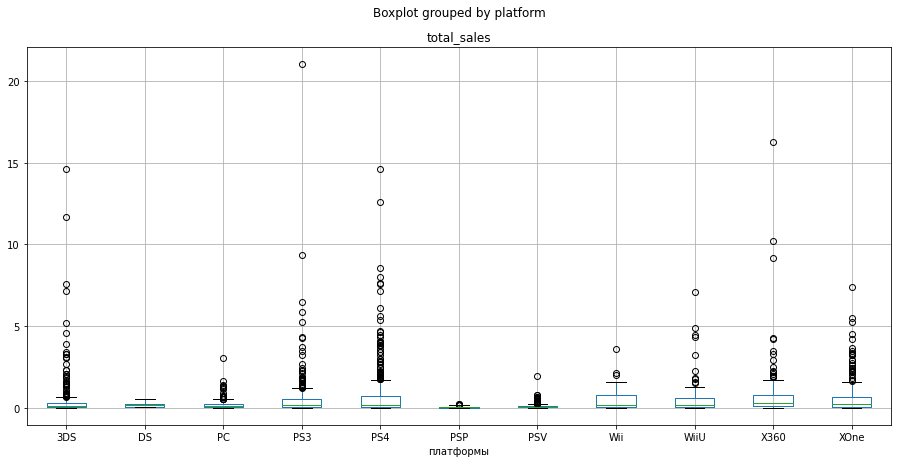

In [88]:
data_1.boxplot(column='total_sales', by='platform', figsize=(15, 7))
plt.xlabel('платформы')
plt.show();

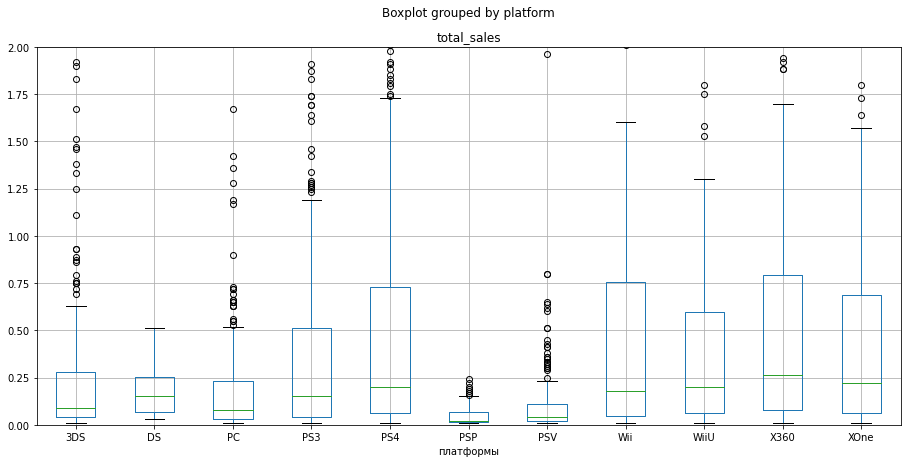

In [89]:
data_1.boxplot(column='total_sales', by='platform', figsize=(15, 7))
plt.xlabel('платформы')
plt.ylim(0,2)
plt.show();

График показывает нам, что приемница выгляд вяло на фоне своего предшественника X360 и показатели ниже в 2 раза с прямым конкурентом консоли PS4. Не самый многообещающий продукт, хотя по медиане приблизительно одинаковы. Стоит отметить, что медиана продаж всех продуктов примерно на одном уровне.

###  Рассмотри матрицы корреляции за период 2011-2016 рынков и оценок игр.

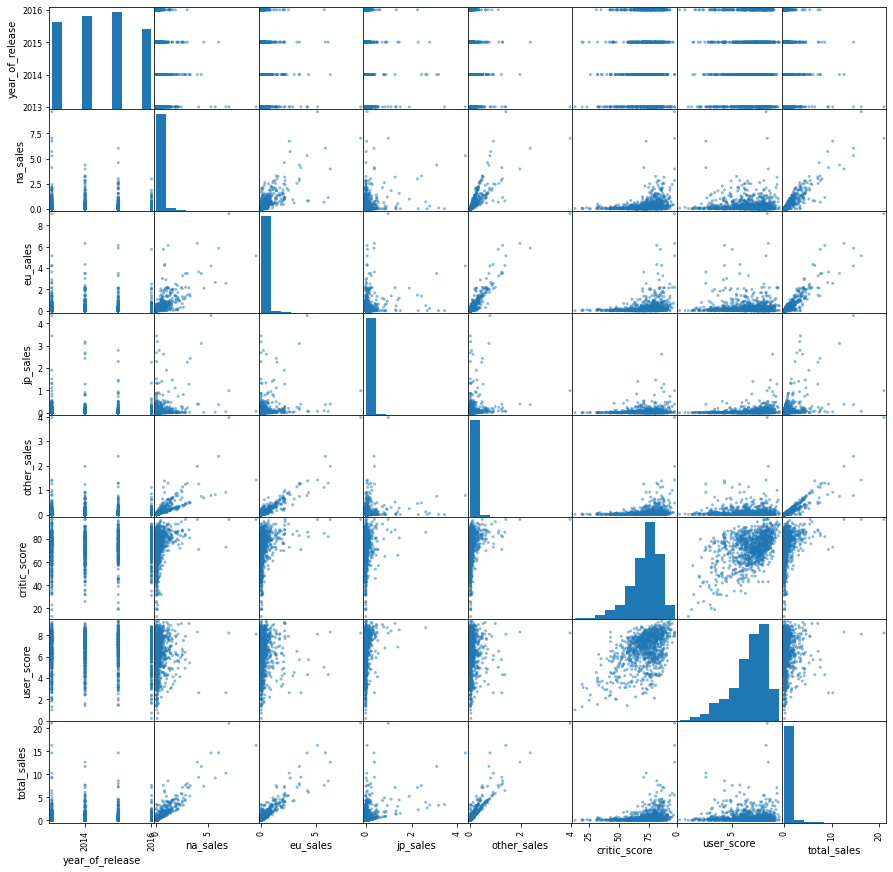

In [90]:
pd.plotting.scatter_matrix(data_1, figsize=(15, 15));

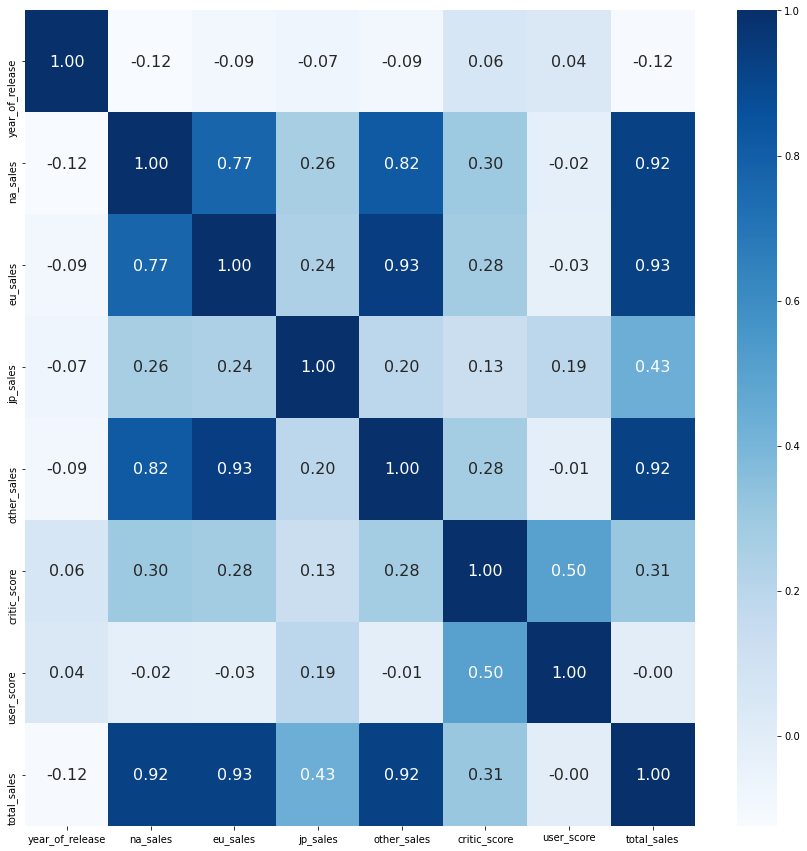

In [91]:
plt.figure(figsize=(15,15))
sns.heatmap(data_1.corr(), annot=True, cmap="Blues", fmt='.2f', annot_kws={'size':16});

Из матрицы видно, что японский рынок слабо коррелирует с продажами во всем мире, тогда как американский и европейский имеет достаточно сильную зависимость. Стоит признать, японский рынок слабо понятен остальному миру. Прослеживается зависимость между оценками критиков и пользователей. Год выпуска не имеет зависимости с другими параметрами.

На примере PS4 и XOne рассмотрим зависимость суммарных продаж от оценки критиков и пользователей, как прямых конкурентов.

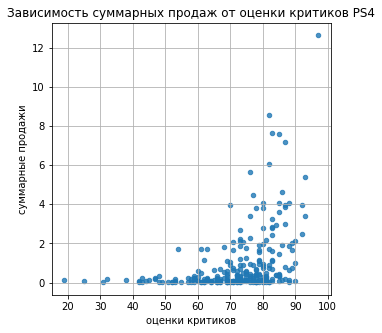

In [92]:
data[data['platform']=='PS4'].plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.8, figsize=(5,5), grid=True)
plt.title("Зависимость суммарных продаж от оценки критиков PS4")
plt.xlabel('оценки критиков')
plt.ylabel('суммарные продажи');

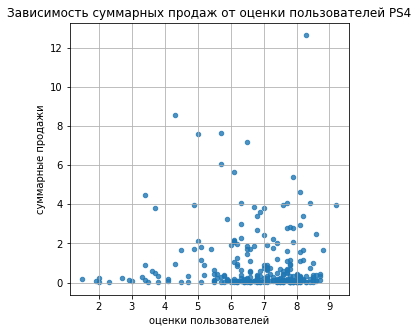

In [93]:
data[data['platform']=='PS4'].plot(x='user_score', y='total_sales', kind='scatter', alpha=0.8, figsize=(5,5), grid=True)
plt.title("Зависимость суммарных продаж от оценки пользователей PS4")
plt.xlabel('оценки пользователей')
plt.ylabel('суммарные продажи');

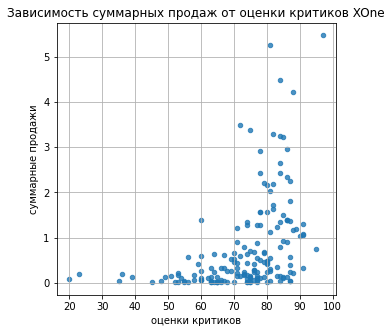

In [94]:
data_1[data_1['platform']=='XOne'].plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.8, figsize=(5,5), grid=True)
plt.title("Зависимость суммарных продаж от оценки критиков XOne")
plt.xlabel('оценки критиков')
plt.ylabel('суммарные продажи');

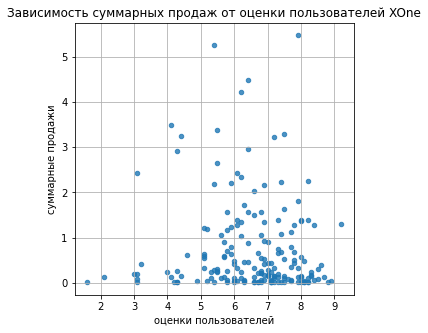

In [95]:
data_1[data_1['platform']=='XOne'].plot(x='user_score', y='total_sales', kind='scatter', alpha=0.8, figsize=(5,5), grid=True)
plt.title("Зависимость суммарных продаж от оценки пользователей XOne")
plt.xlabel('оценки пользователей')
plt.ylabel('суммарные продажи');

In [96]:
list = (['critic_score', 'user_score', 'total_sales'])

In [97]:
data_1.loc[:,list].corr()

,critic_score,user_score,total_sales
critic_score,1.00,0.50,0.31
user_score,0.50,1.00,-0.00
total_sales,0.31,-0.00,1.00


Из матриц видно, что зависимость слабая или слабопрослеживающаяся. Мы не можем с уверенностью сказать, что оценки имеют зависимость от суммарных продаж.

### Общее распределение игр по жанрам 

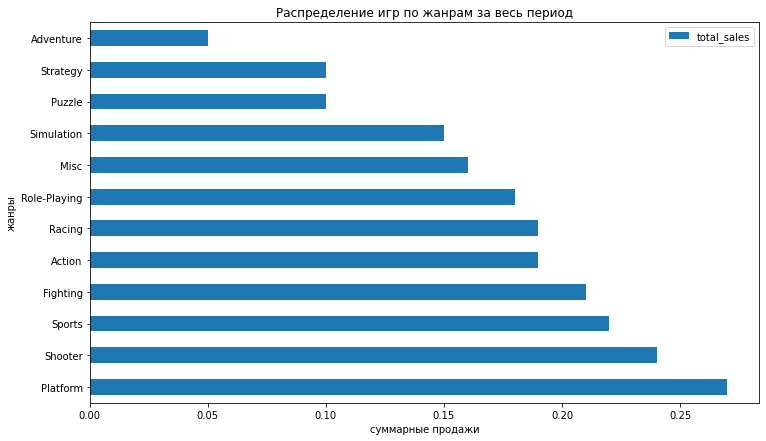

In [98]:
data.pivot_table(index='genre', values='total_sales', aggfunc='median') \
    .sort_values(by='total_sales', ascending=False) \
    .plot(kind='barh', figsize=(12,7))
plt.xlabel('суммарные продажи')
plt.ylabel('жанры')
plt.title("Распределение игр по жанрам за весь период");

Весь период у нас охватывает 36 лет,  и самыми полюбившимися жанрами за это время стали:
- Platform
- Shooter
- Sports
- Fightening
- Action


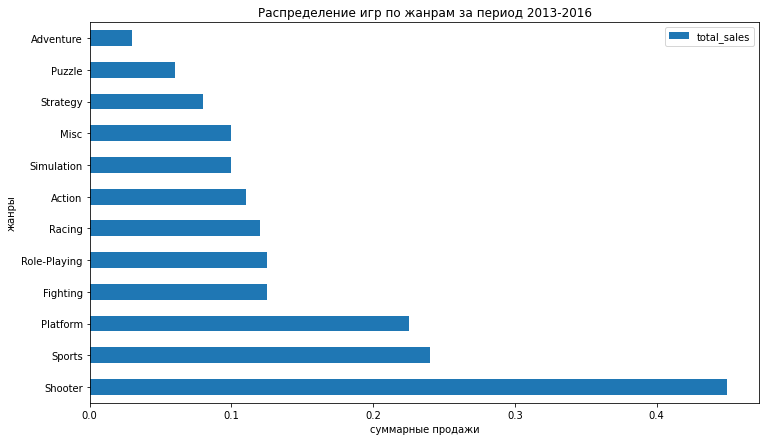

In [99]:
data_1.pivot_table(index='genre', values='total_sales', aggfunc='median') \
    .sort_values(by='total_sales', ascending=False) \
    .plot(kind='barh', figsize=(12,7))
plt.xlabel('суммарные продажи')
plt.ylabel('жанры')
plt.title("Распределение игр по жанрам за период 2013-2016");

За рассматриваемый период в 5 лет предпочтения немного сменились:
- Shooter (стоит отметить, что в последнее время жанры Action и Shooter стали объединять, что и привело к снижению интереса как отдельного жанра)
- Sports
- Platform
- Fightening
- RPG (ролевые игры стали популярнее, так как графика и сюжеты стали сложнее и лучше)


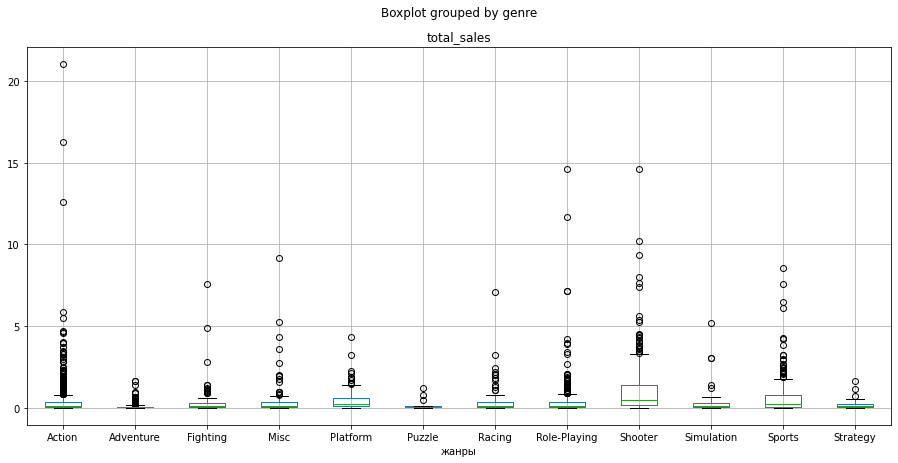

In [100]:
data_1.boxplot(column='total_sales', by='genre', figsize=(15, 7))
plt.xlabel('жанры')
plt.show();

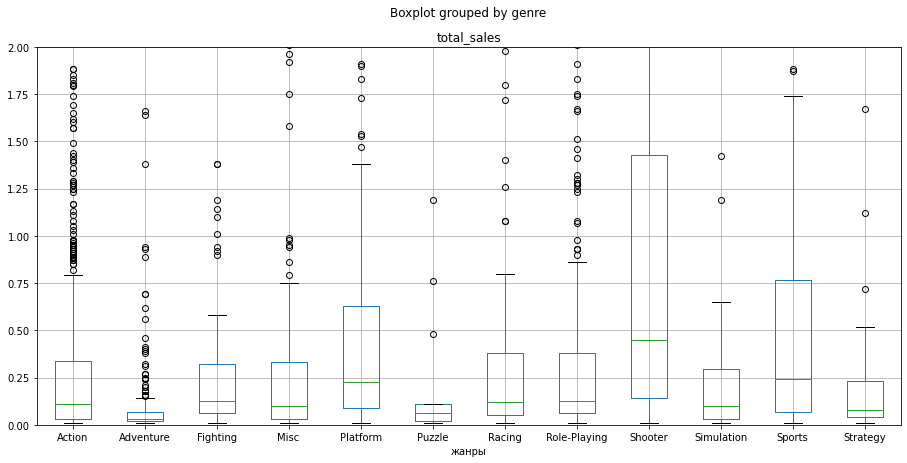

In [101]:
data_1.boxplot(column='total_sales', by='genre', figsize=(15, 7))
plt.xlabel('жанры')
plt.ylim(0,2)
plt.show();

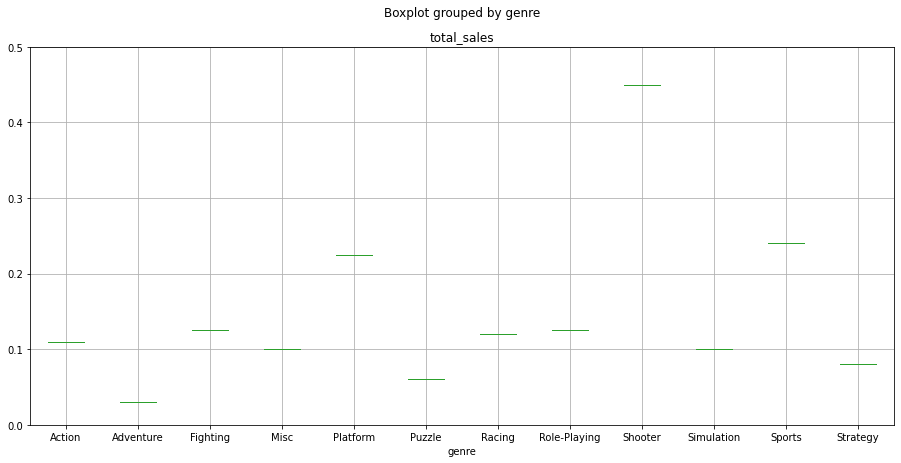

In [102]:
data_1.pivot_table(index='genre', values='total_sales', aggfunc='median').boxplot(column='total_sales', by='genre', figsize=(15,7))
plt.ylim(0,0.5)
plt.show()

Медиана Shooter выше остальных жанров, Sports, Platform так же достаточно прибыльные жанры, остальные менее успешные у пользователей.

**Вывод:**  исследовательский анализ позволил выявить  несколько закономерностей:

 - мы рассмотрели период в 36 лет, быстрый темп роста игровых консолей начался в 2002 г(активное развитие Microsoft и появление на рынке Microsoft XP) и продлился вплоть до 2013 г, стоит отметить, что на это повлияло рост американского рынка, дальнейшее снижение связываю с переходом американского сегмента на более закрытую систему Apple, развитие смартфонов;
 - самыми популярными консолями были PS2 - самая продаваемая модель во всем мире, X360, PS3, PS,  nintendo (Wii, DS); на столбчатых диаграмах по году, мы видим как одно поколение накладывается на другое(разработки идут параллельно, когда начинается снижение интереса к предшественнику, выходит новое поколение, тем самым, наблюдается непрерывность процесса);
 - по диаграммам и таблицам определили среднюю продолжительность жизни игровых платформ, 7 лет, далее имеется необходимость выводить на рынок новый продукт;
 - изучили период 3 года(2013-2016), определили прямых конкурентов с наибольшими долями продаж  XOne, PS4, стоит отметить, что "иксбокс" успает "сони", а XOne менее удачный проект;
 - анализ ящика с усами показал некотрую модель поведения платформ, например, у некоторых выбросы небольшие, и можно сказать, что выпуск продуктов был "среднего" успеха, в то время, как лидеры продаж делали ставки на "выстрел" продукта на рынке(уверенна, что на этом сказывается и финансирование платформ), медиана продаж платформ примерно на одном уровне;
 - рассмотрели поведение ярко конкурирующих платформ, XOne явно проигрывает в этой стратегии.
 - изучили матрицу корреляции: японский рынок слабо коррелирует с продажами во всем мире, тогда как американский и европейский имеет достаточно сильную зависимость, наблюдается зависимость в оценках критиков и пользователей;
 - а вот диаграммы рассеивания не потвердили зависимость оценок пользователей и критиков от суммарных продаж;
 - предпочтения по жанру за весь период и за выбранный (3 года) немного отличается, с перекосом на "стрелялки", но так же мы уже отметили, что "экшн" смешался с Shooter, интерес к платформерам снизился в связи с появлением хорошей и сложной реализацией более активных жанров.
 

##  Портрет пользователя каждого региона

Определим для пользователя каждого региона NA, EU, JP предпочтения по платформе, жанру и рейтингу ESRB.

### Самые популярные платформы (топ-5). 

Рассмотрим популярные платформы по рынкам NA, EU, JP.

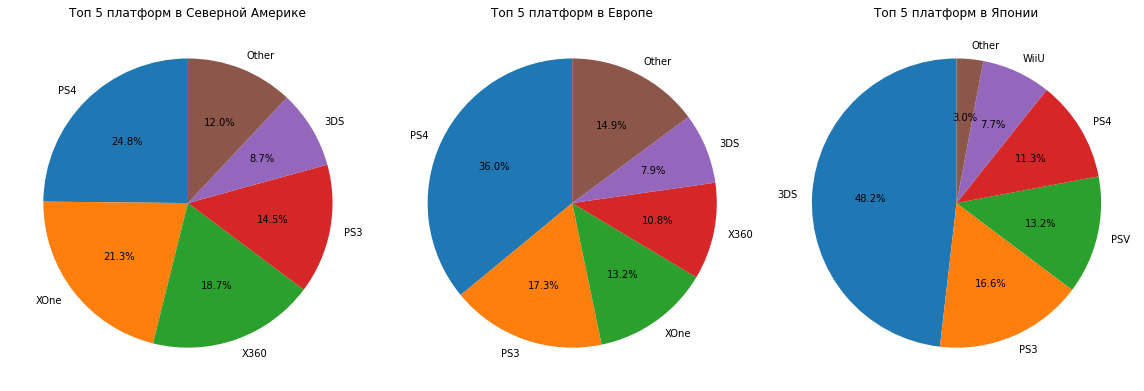

In [103]:
fig, axs = plt.subplots(1, 3, figsize=(16, 10))
sns.set_palette("Set2")
# na
na_total = data_1.groupby('platform')['na_sales'].sum().sort_values(ascending=False)
top_na = na_total.head(5)
other = na_total.tail(len(na_total) - 5).sum()

labels_na = top_na.index.tolist() + ['Other']
sizes_na = top_na.tolist() + [other]


axs[0].pie(sizes_na, labels=labels_na, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Топ 5 платформ в Северной Америке')

# eu
eu_total = data_1.groupby('platform')['eu_sales'].sum().sort_values(ascending=False)
top_eu = eu_total.head(5)
other_eu = eu_total.tail(len(eu_total) - 5).sum()

labels_eu = top_eu.index.tolist() + ['Other']
sizes_eu = top_eu.tolist() + [other_eu]

axs[1].pie(sizes_eu, labels=labels_eu, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Топ 5 платформ в Европе')

# jp
jp_total = data_1.groupby('platform')['jp_sales'].sum().sort_values(ascending=False)
top_jp = jp_total.head(5)
other_jp = jp_total.tail(len(jp_total) - 5).sum()

labels_jp = top_jp.index.tolist() + ['Other']
sizes_jp = top_jp.tolist() + [other_jp]


axs[2].pie(sizes_jp, labels=labels_jp, autopct='%1.1f%%', startangle=90)
axs[2].set_title('Топ 5 платформ в Японии')

plt.tight_layout()
plt.show()

Американские пользователи в равноей степени предпочитают microsoft(X360, XOne) и продукцию "сони"(PS4, PS3), почти 80 % американского рынка, далее nintendo 3DS около 9% рынка.

Вкусы европейцев почти совпадают с американскими ковбоями, с отличием большей долей японских приставок "PS", Мic всего 24%.

Японцы патриотично выбирают своих производителей, и nintendo в топе, более 55% всех продаж, 3DS занимает почти 50% японского сегмента.

### Самые популярные жанры (топ-5).

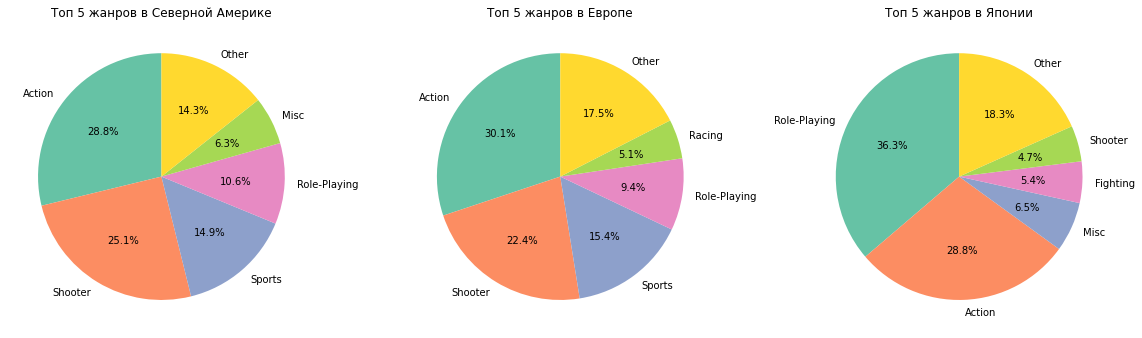

In [104]:
fig, axs = plt.subplots(1, 3, figsize=(16, 10))
sns.set_palette("Set2")
# na
na_genre = data_1.groupby('genre')['na_sales'].sum().sort_values(ascending=False)
na_genre_top = na_genre.head(5)
other_genre = na_genre.tail(len(na_genre) - 5).sum()

labels_na_genre = na_genre_top.index.tolist() + ['Other']
sizes_na_genre = na_genre_top.tolist() + [other_genre]


axs[0].pie(sizes_na_genre, labels=labels_na_genre, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Топ 5 жанров в Северной Америке')

# eu
eu_genre = data_1.groupby('genre')['eu_sales'].sum().sort_values(ascending=False)
top_eu_genre = eu_genre.head(5)
other_eu_genre = eu_genre.tail(len(eu_genre) - 5).sum()

labels_eu_genre = top_eu_genre.index.tolist() + ['Other']
sizes_eu_genre = top_eu_genre.tolist() + [other_eu_genre]

axs[1].pie(sizes_eu_genre, labels=labels_eu_genre, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Топ 5 жанров в Европе')

# jp
jp_genre = data_1.groupby('genre')['jp_sales'].sum().sort_values(ascending=False)
top_jp_genre = jp_genre.head(5)
other_jp_genre = jp_genre.tail(len(jp_genre) - 5).sum()

labels_jp_genre = top_jp_genre.index.tolist() + ['Other']
sizes_jp_genre = top_jp_genre.tolist() + [other_jp_genre]


axs[2].pie(sizes_jp_genre, labels=labels_jp_genre, autopct='%1.1f%%', startangle=90)
axs[2].set_title('Топ 5 жанров в Японии')

plt.tight_layout()
plt.show()

Северная Америка предпочитает максимально активные игры - "экшн, спрот, стрелялки", и 31.2% иного формата игр.

Европейский рынок снова показывает схожую картину, предпочтения немного отличаются в процентах. На диаграмме видно, что европейский рынок любит "гоночки"

Япноский сегмент захватили "РПГэшки", почти треть рынка, Action так же занимает значительную долю рынка,  остальные жанры интересуют японского пользователя меньше.

### Влияние рейтинга ESRB на продажи в каждом регионе регионе.

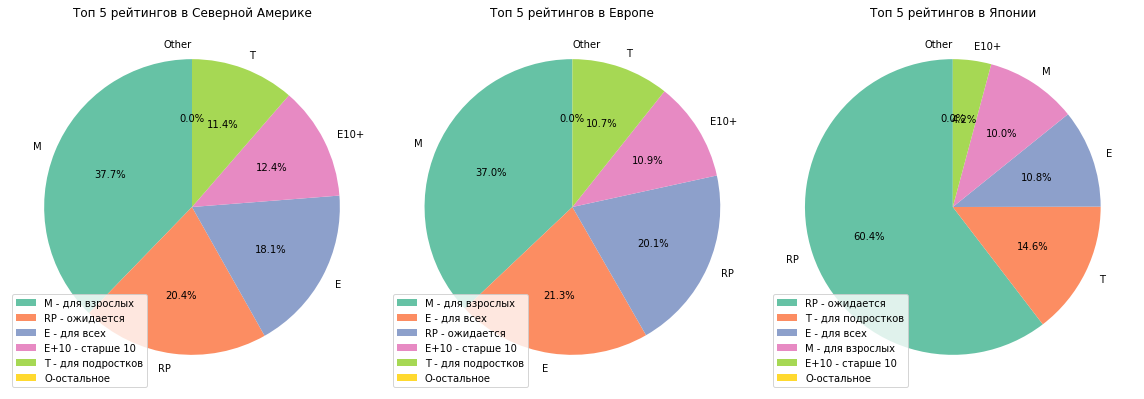

In [105]:
fig, axs = plt.subplots(1, 3, figsize=(16, 10))
sns.set_palette("Set2")

# na
na_rating = data_1.groupby('rating')['na_sales'].sum().sort_values(ascending=False)
na_rating_top = na_rating.head(5)
other_rating = na_rating.tail(len(na_rating) - 5).sum()

labels_na_rating = na_rating_top.index.tolist() + ['Other']
sizes_na_rating = na_rating_top.tolist() + [other_rating]

axs[0].pie(sizes_na_rating, labels=labels_na_rating, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Топ 5 рейтингов в Северной Америке')
axs[0].legend(['M - для взрослых', 'RP - ожидается ', 'E - для всех', 'E+10 - старше 10', 'T - для подростков', 'O-остальное'], 
              loc='lower left')

# eu
eu_rating = data_1.groupby('rating')['eu_sales'].sum().sort_values(ascending=False)
top_eu_rating = eu_rating.head(5)
other_eu_rating = eu_rating.tail(len(eu_rating) - 5).sum()

labels_eu_rating = top_eu_rating.index.tolist() + ['Other']
sizes_eu_rating = top_eu_rating.tolist() + [other_eu_rating]

axs[1].pie(sizes_eu_rating, labels=labels_eu_rating, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Топ 5 рейтингов в Европе')
axs[1].legend(['M - для взрослых', 'E - для всех', 'RP - ожидается ', 'E+10 - старше 10', 'T - для подростков', 'O-остальное'], 
              loc='lower left')
# jp
jp_rating = data_1.groupby('rating')['jp_sales'].sum().sort_values(ascending=False)
top_jp_rating = jp_rating.head(5)
other_jp_rating = jp_rating.tail(len(jp_rating) - 5).sum()

labels_jp_rating = top_jp_rating.index.tolist() + ['Other']
sizes_jp_rating = top_jp_rating.tolist() + [other_jp_rating]


axs[2].pie(sizes_jp_rating, labels=labels_jp_rating, autopct='%1.1f%%', startangle=90)
axs[2].set_title('Топ 5 рейтингов в Японии')
axs[2].legend(['RP - ожидается', 'T - для подростков', 'E - для всех', 'M - для взрослых', 'E+10 - старше 10', 'O-остальное'], 
              loc='lower left')

plt.tight_layout()
plt.show()

На диаграмме СА пользуются популярностью игры, относящиеся к рейтингу "для взрослых", далее 1/5 рынка с играми, рейтинг, которых до сих пор не был определен, далее "для всех", и 1/8 для детей старше 10 лет.

У европейского рынка так же превалируют игры для взрослых, далее для всех пользователей, похожая картина с играми без рейтинга, и менее 1/8 для детей старше 10 лет.

Почти 60 % игр ожидают рейтинга, далее для подростков немного больше 1/8, еще почти 1/8 доля рынка для  всех пользователей, и 1/10 для взрослых.

**Вывод:** выведем портеры ярких представителей по сегментам рынка:
- Северная Америка: наиболее полюбившиеся платформы почти в равной степени microsoft(X360, XOne) и продукцию "сони"(PS4, PS3), любимые жанры   Action, Sports, Shooter с возрастными отметками для взрослых, без рейтинга,всех;
- Европа по части платформ и жанров очень похожа на американский рынок,  отличия в процентах, так же для взрослых, для всех и без рейтинга;
- Японский сегмент рынка предпочитает японские платформы nintendo, PS, с играми без рейтинга и для подростов, и жанрами  Action, самым востребованными "РПГэшками" (RPG- ролевые игры) и другие.

## Шаг 5. Проверка гипотез

Проверим две гипотезы:

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Для проверки обеих гипотез будем использовать двухвыборочный t-тест с несвязанными выборками и тест Стьюдента(сравнение средних значений по двум выборкам).Более низкие значения P(pvalue - вероятность того, что результаты выборки произошли случайно) указывают на то, что данные были получены не случайно. Как правило, во многих случаях значение P, равное 5%, то есть 0,05, принимается для того, чтобы обозначить, что данные считаются достоверными.

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Проверим гипотезу: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

H_0: пользовательские рейтинги платформы XOne = пользовательским рейтингам платформы PC.

H_1: пользовательские рейтинги платформы XOne != пользовательским рейтингам платформы PC.

alpha = 0.05

In [106]:
xbox = data[data['platform'] == 'XOne']
pc = data[data['platform'] == 'PC']

xbox_us = xbox['user_score'].dropna()
pc_us = pc['user_score'].dropna()
alpha = 0.05

t_statistic, p_value = ttest_ind(xbox_us, pc_us)

print("T-статистика:", t_statistic)
print("P-значение:", p_value)


if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

T-статистика: -4.366816790436842
P-значение: 1.4016009044865732e-05
Отвергаем нулевую гипотезу


In [107]:
# Приведены два датасета: сумма покупок, совершённых за месяц посетителями ...

sample_1 = [3071, 3636, 3454, 3151, 2185, 3259, 1727, 2263, 2015,
2582, 4815, 633, 3186, 887, 2028, 3589, 2564, 1422, 1785,
3180, 1770, 2716, 2546, 1848, 4644, 3134, 475, 2686,
1838, 3352]
sample_2 = [1211, 1228, 2157, 3699, 600, 1898, 1688, 1420, 5048, 3007,
509, 3777, 5583, 3949, 121, 1674, 4300, 1338, 3066,
3562, 1010, 2311, 462, 863, 2021, 528, 1849, 255,
1740, 2596]
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
sample_1,
sample_2)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1912450522572209
Не получилось отвергнуть нулевую гипотезу


In [108]:
xbox_us.mean()

6.521428

In [109]:
pc_us.mean()

7.0640583

**Вывод:** отвергаем нулевую гипотезу, что пользовательские рейтинги обеих платформ равны. После вывода средних обеих платформ можем наблюдать схожий результат. Отметим, популярность ПК  связана со многими факторами, в том числе, что и сама система открытая, в отличаи от "иксбокс", и позволяет обходить некоторые ограничения на скачивания, а так же пользоваться преимуществами сочетания игр с большинства других популярных платформ(как правило, на ПК игры выходят с некоторым запозданием).

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Проверим гипотезу: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

H_0: пользовательские рейтинги жанров Action = пользовательским рейтингам жанров Sports

H_1: пользовательские рейтинги жанров Action != пользовательским рейтингам жанров Sports

alpha = 0.05

In [110]:
action = data[data['genre'] == 'Action']
sports = data[data['genre'] == 'Sports']

action = action['user_score']
sports= sports['user_score']
alpha = .05 

results = st.ttest_ind(action, sports, nan_policy='omit')

print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.06833629685831427
Не получилось отвергнуть нулевую гипотезу


In [111]:
action.mean()

7.0581293

In [112]:
sports.mean()

6.952778

In [113]:
action.mean()- sports.mean()

0.10535145

**Вывод:**  не получилось отвергнуть нулевую гипотезу о том, что пользовательские рейтинги жанров Action равны пользовательским рейтингам жанров Sports. Как мы видим из средних обоих значений, разница их рейтингов всего 0.1.

**Вывод:**   мы отверги гипотезу о равенстве интересов пользователей к PC и  XOne. По средним значениям мы подтвердили результат в пользу первого(7,06 против 6,52). И не смогли опровергнуть вторую гипотезу, о том, что пользовательские рейтинги жанров Action равны пользовательским рейтингам жанров Sports.

## Шаг 6. Общий вывод.

Мы провели анализ данных по играм за 36 лет (1980-2016 гг).

Анализ проводился в несколько этапов: предработка данных, исследовательский анализ,  изучение портрета пользователя каждого региона, проверка гипотез.

Первым этапом  были изучены и отработны данные для дальнейшего анализа: перевод заголовков в нижний регистр, обработка пропусков в столбцах жанра и имени, рейтинга, года выпуска, замена tbd на nan в оценках пользователей, в ESRB рейтингах были произведены замены пропусков на RP, NoRating, объединены некоторые категории, а так же принято решение не обрабатывать пропуски в оценочных столбцах критиков и пользователей, так как это может навредить достоверности данным. Данные были понижены в разряде для экономии ресурса.
 
На втором этапе  изучили: 
- быстрый темп роста игровых консолей начался в 2002 г(активное развитие Microsoft и появление на рынке Microsoft XP) и продлился вплоть до 2013 г;
 - самыми популярными консолями были PS2 - самая продаваемая модель во всем мире, X360, PS3, PS,  nintendo (Wii, DS); 
 - по диаграммам и таблицам определили среднюю продолжительность жизни игровых платформ, 7 лет, далее имеется необходимость выводить на рынок новый продукт;
 - изучили период 3 года(2013-2016), определили прямых конкурентов с наибольшими долями продаж  XOne, PS4, стоит отметить, что "иксбокс" успает "сони", а XOne менее удачный проект;
 - анализ ящика с усами показал некотрую модель поведения платформ, например, у некоторых выбросы небольшие, и можно сказать, что выпуск продуктов был "среднего" успеха, в то время, как лидеры продаж делали ставки на "выстрел" продукта на рынке(уверенна, что на этом сказывается и финансирование платформ), медиана продаж платформ примерно на одном уровне;
 - рассмотрели поведение ярко конкурирующих платформ, XOne явно проигрывает в этой стратегии.
 - изучили матрицу корреляции: японский рынок слабо коррелирует с продажами во всем мире, тогда как американский и европейский имеет достаточно сильную зависимость, наблюдается зависимость в оценках критиков и пользователей;
 - а вот диаграммы рассеивания не потвердили зависимость оценок пользователей и критиков от суммарных продаж;
 - предпочтения по жанру за весь период и за выбранный (3 года) немного отличается, с перекосом на "стрелялки", но так же мы уже отметили, что "экшн" смешался с Shooter, интерес к платформерам снизился в связи с появлением хорошей и сложной реализацией более активных жанров.
 
На третьем составили портрет каждого пользователя:
- Северная Америка: наиболее полюбившиеся платформы почти в равной степени microsoft(X360, XOne) и продукцию "сони"(PS4, PS3), любимые жанры   Action, Sports, Shooter с возрастными отметками для взрослых, без рейтинга,всех;
- Европа по части платформ и жанров очень похожа на американский рынок,  отличия в процентах, так же для взрослых, для всех и без рейтинга;
- Японский сегмент рынка предпочитает японские платформы nintendo, PS, с играми без рейтинга и для подростов, и жанрами  Action, самым востребованными "РПГэшками" (RPG- ролевые игры) и другие.

И завершающий этап - проверка гипотез:
 - отвергли гипотезу о равенстве интересов пользователей к PC и  XOne. А результат средних в пользу первого(7,06 против 6,52);
 - не смогли опровергнуть вторую гипотезу, о том, что пользовательские рейтинги жанров Action равны пользовательским рейтингам жанров Sports.



**Рекомендации:**
- Для более точного прогноза хотелось бы изучить китайский, индийский и россиские рынки( первые для изучения тенденций, росрынок для планирования сбыта)
- Предоставлять информацию в максимально подготовленном виде, чтобы избежать траты на времени на этап предработки.